In [0]:
from fbprophet import Prophet
from torch.utils.data.sampler import SubsetRandomSampler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

In [0]:
bdenv_loc = '/content/drive/My Drive/Colab Notebooks/data/733project/Neighbourhood_model_data.csv'
#bdata = os.path.join(bdenv_loc,'data')

In [24]:
df = pd.read_csv(bdenv_loc)
df.dtypes

NEIGHBOURHOOD_NAME        object
TAX_ASSESSMENT_YEAR        int64
PREVIOUS_MEDIAN_PRICE    float64
INTEREST_RATE            float64
CURRENT_MEDIAN_PRICE     float64
dtype: object

In [25]:
df.index = pd.to_datetime(df['TAX_ASSESSMENT_YEAR'], format='%Y')
df

,NEIGHBOURHOOD_NAME,TAX_ASSESSMENT_YEAR,PREVIOUS_MEDIAN_PRICE,INTEREST_RATE,CURRENT_MEDIAN_PRICE
TAX_ASSESSMENT_YEAR,,,,,
2007-01-01,Arbutus-Ridge,2007,0.80475,6.104167,1.01700
2008-01-01,Arbutus-Ridge,2008,1.01700,4.729167,1.22905
2009-01-01,Arbutus-Ridge,2009,1.22905,2.395833,1.23490
2010-01-01,Arbutus-Ridge,2010,1.23490,2.604167,1.22900
2011-01-01,Arbutus-Ridge,2011,1.22900,3.000000,1.51500
2012-01-01,Arbutus-Ridge,2012,1.51500,3.000000,1.90910
2013-01-01,Arbutus-Ridge,2013,1.90910,3.000000,1.82600
2014-01-01,Arbutus-Ridge,2014,1.82600,3.000000,1.82455
2015-01-01,Arbutus-Ridge,2015,1.82455,2.775000,1.98200


In [26]:
area_list = df.NEIGHBOURHOOD_NAME.unique()
print(area_list)

['Arbutus-Ridge' 'Downtown' 'Dunbar-Southlands' 'Fairview'
 'Grandview-Woodland' 'Hastings-Sunrise' 'Kensington-Cedar Cottage'
 'Kerrisdale' 'Killarney' 'Kitsilano' 'Marpole' 'Mount Pleasant'
 'Oakridge' 'Renfrew-Collingwood' 'Riley Park' 'Shaughnessy'
 'South Cambie' 'Sunset' 'Victoria-Fraserview' 'West End'
 'West Point Grey']


In [0]:
def make_comparison_dataframe(historical, forecast):
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:n_changepoints greater than number of observations.Using 7.0.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run

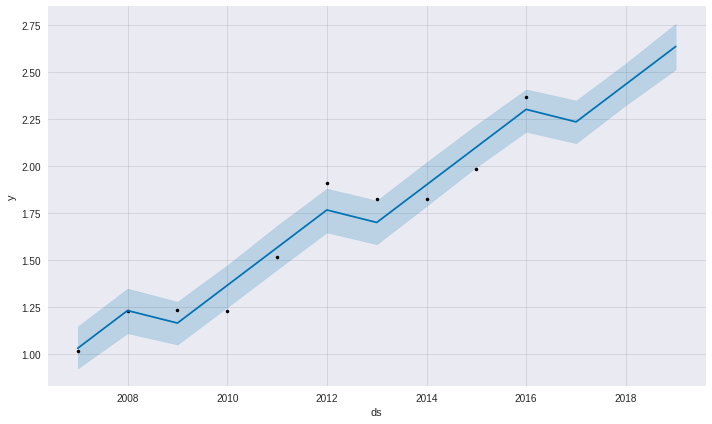

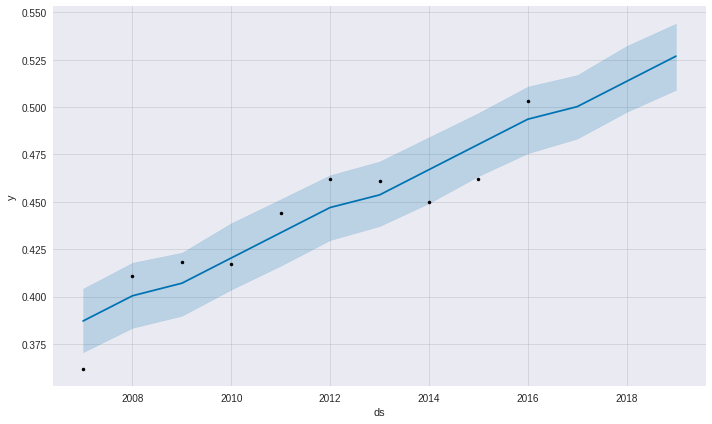

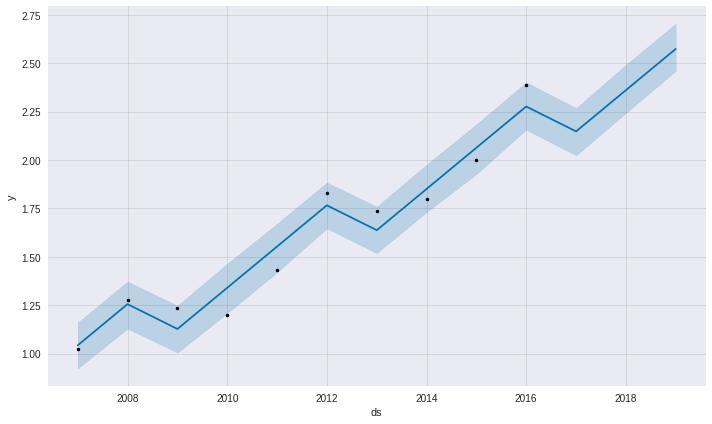

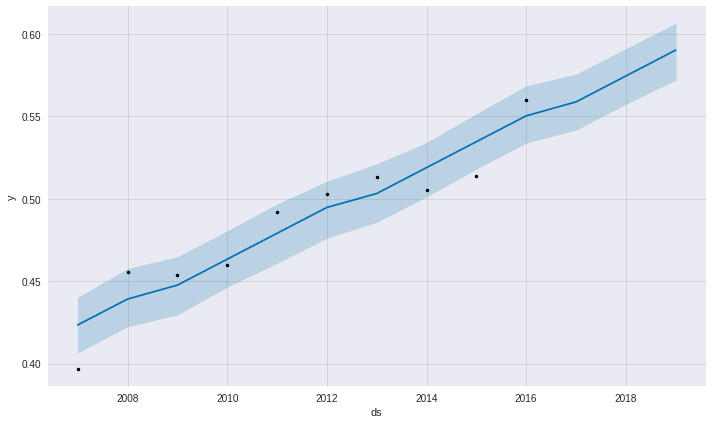

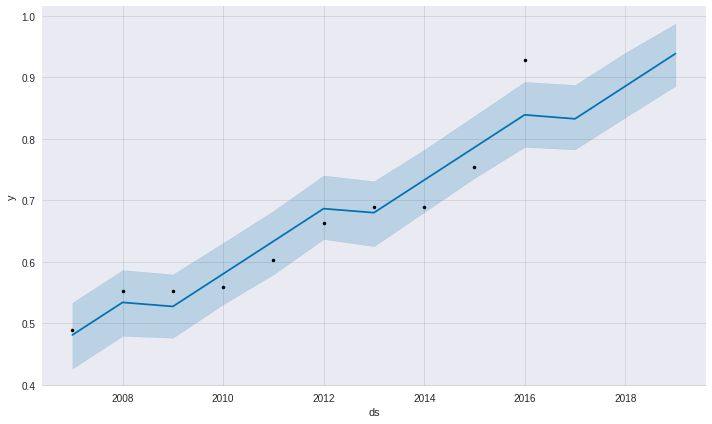

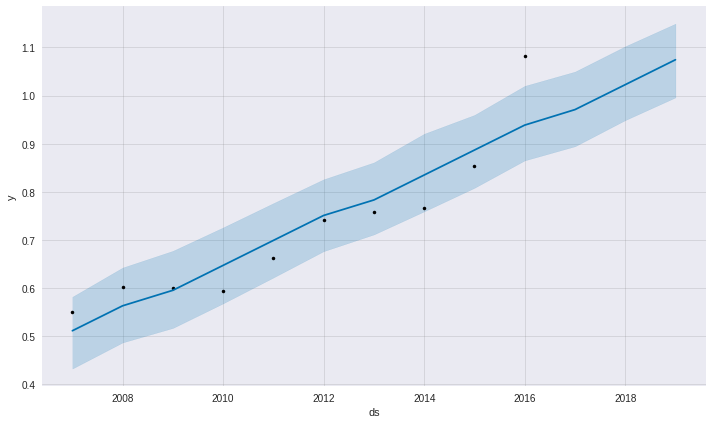

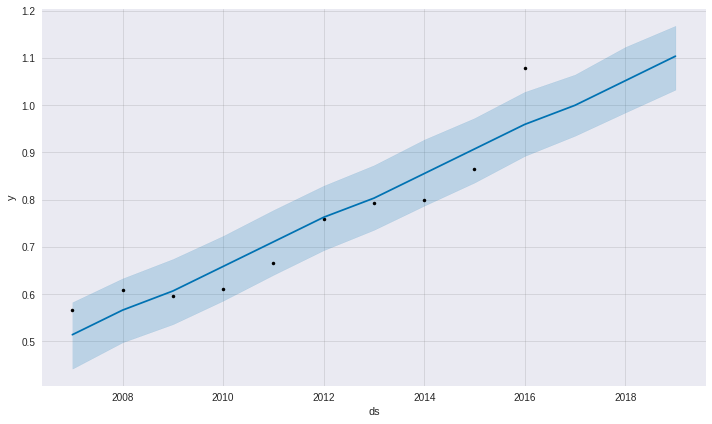

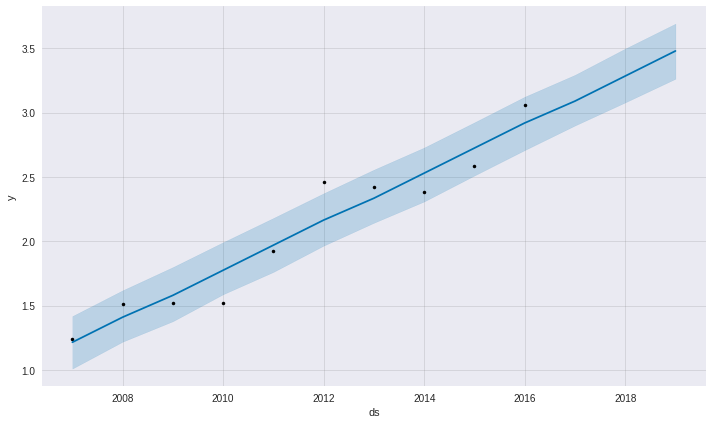

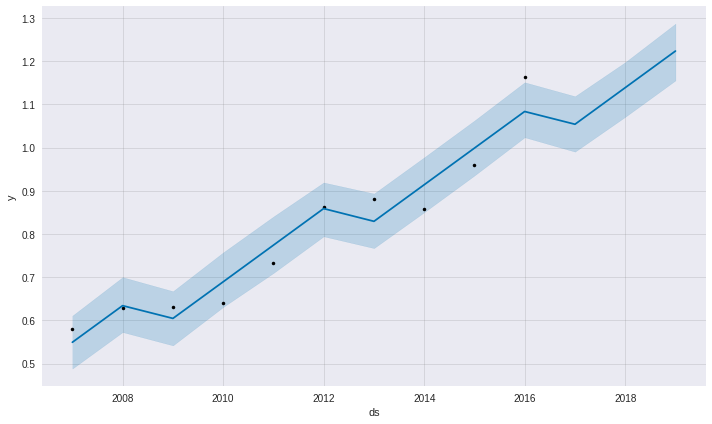

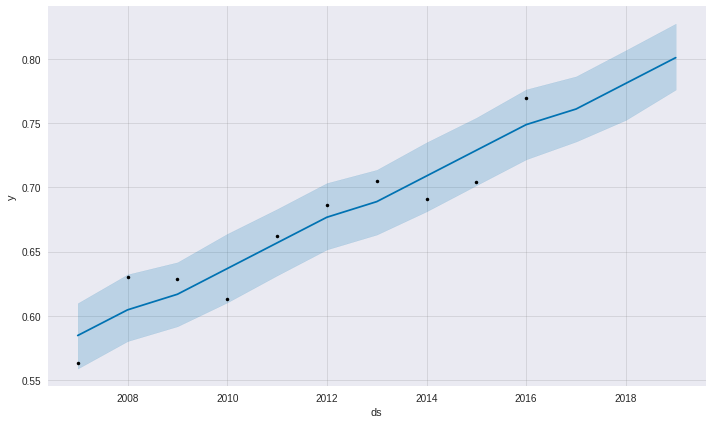

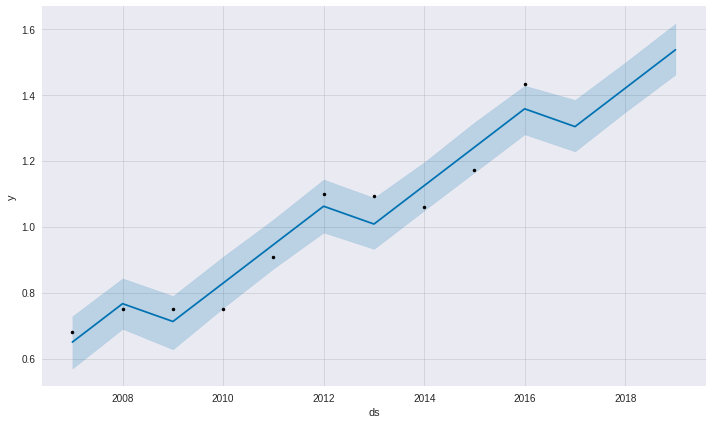

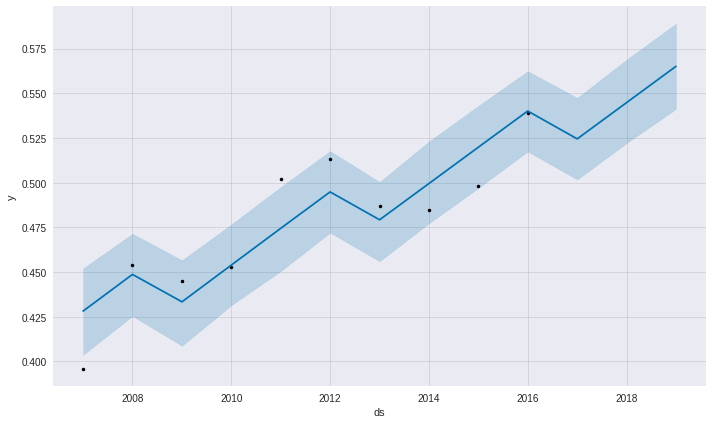

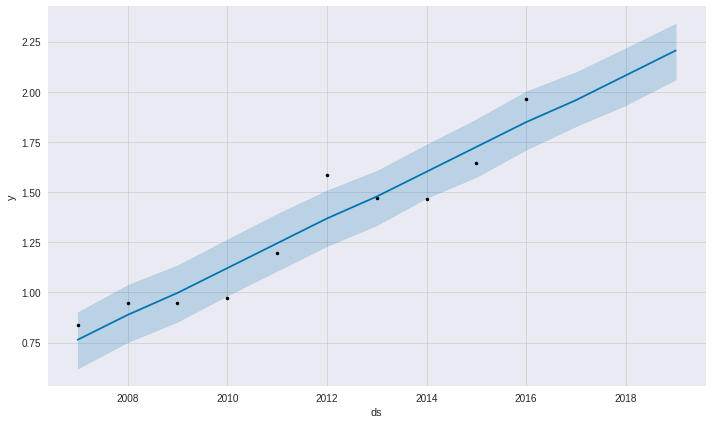

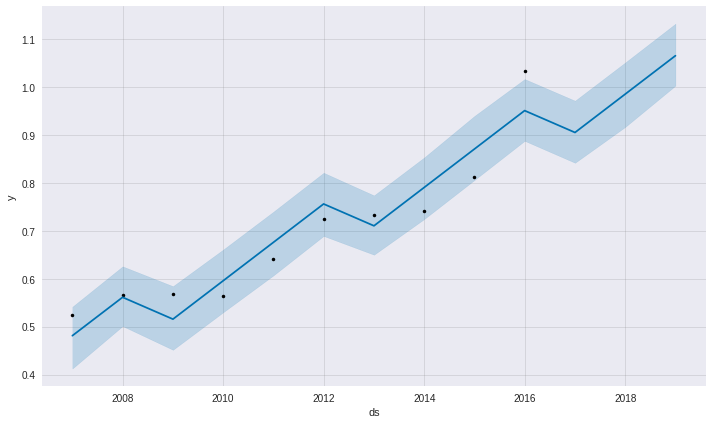

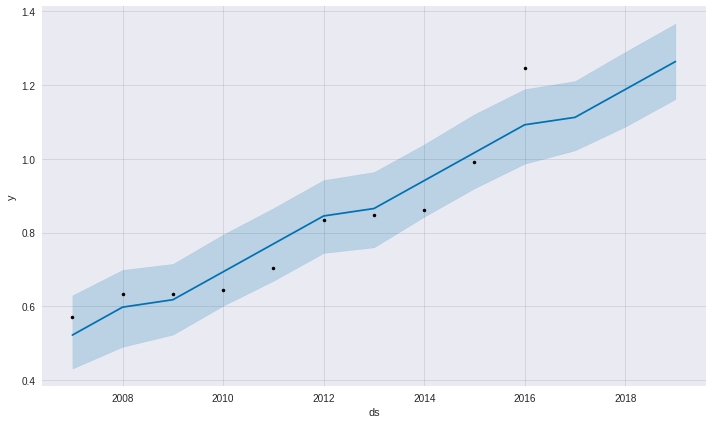

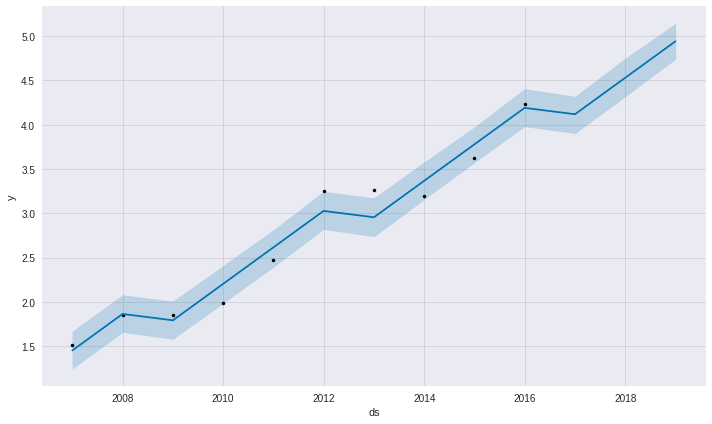

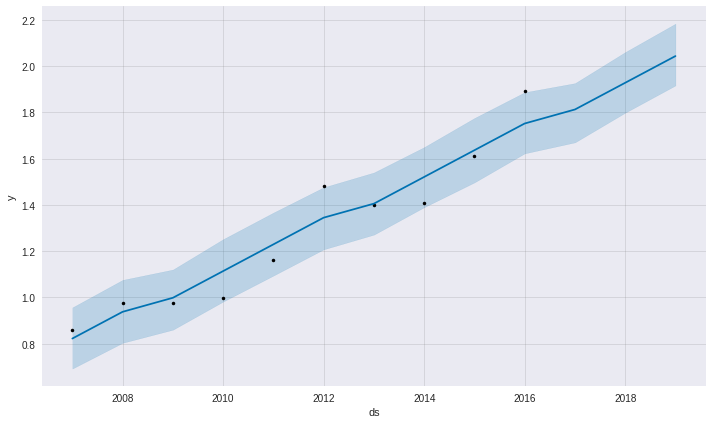

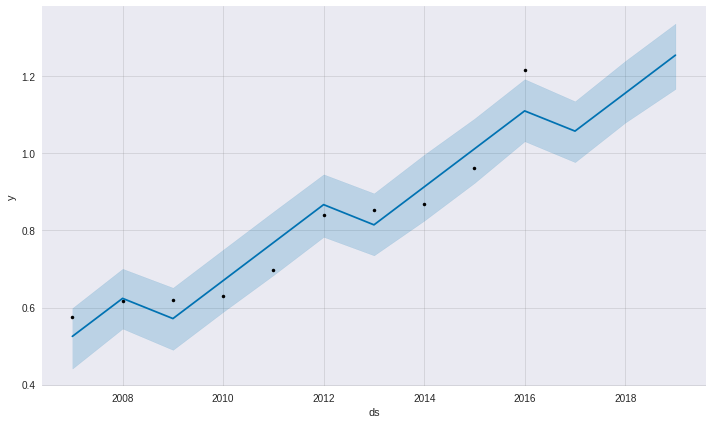

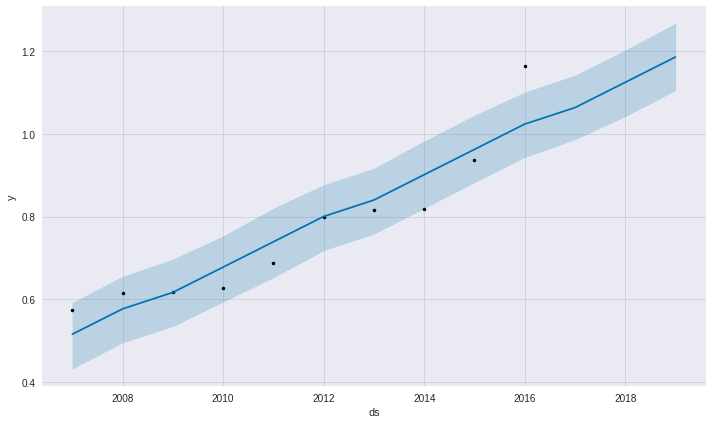

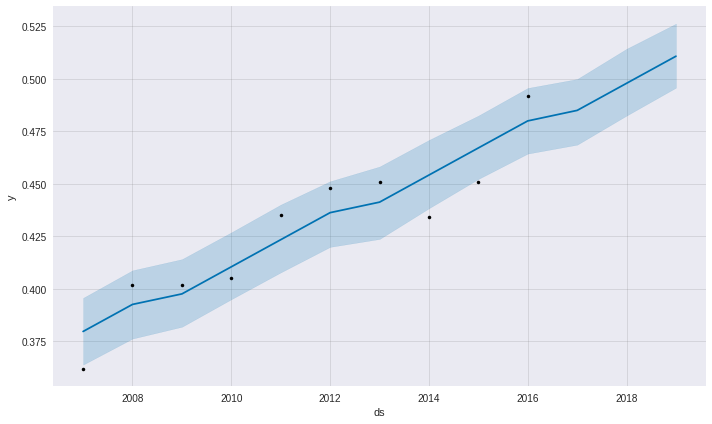

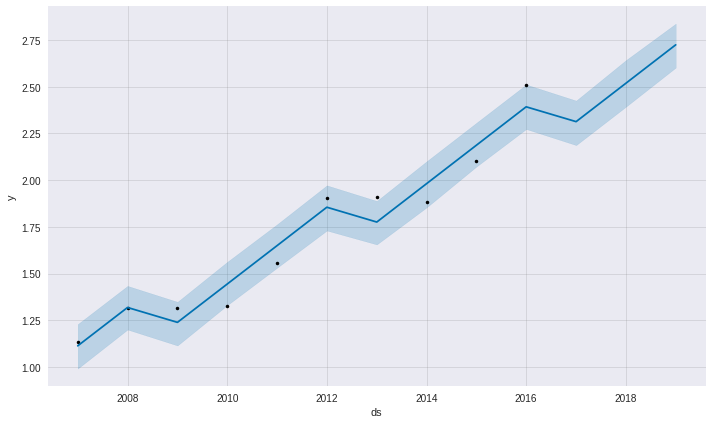

In [34]:
from sklearn.metrics import mean_squared_error
from math import sqrt

rmse_list = []

for area in area_list:
  single_area_df = df.query('NEIGHBOURHOOD_NAME == @area')
  truncated_df = single_area_df[['CURRENT_MEDIAN_PRICE']]
  data = truncated_df.reset_index()
  data.columns = ['ds', 'y']
  
  # train validate split
  prediction_size = 3

  train_df = data[:-prediction_size]
  
  validation_df = data[-prediction_size:]

   # create prophet model and fit on the dataset
  m = Prophet()
  m.fit(train_df)
  
  
  future = data[['ds']]

  forecast = m.predict(future)
  
  m.plot(forecast)
  
  cmp_df = make_comparison_dataframe(data, forecast)
  
  rmse_val = sqrt(mean_squared_error(cmp_df['yhat'], cmp_df['y']))

  rmse_list.append(rmse_val)

In [35]:
average_rmse = np.mean(rmse_list)
average_rmse

0.22445650752917198